# Accelerating Randomized Smoothing

This is the code for our paper "Estimating the Robustness Radius for Randomized Smoothing with 100× Sample Efficiency" (ECAI'24, SAIAD @ CVPR'24). This is the main notebook, walking through the main ideas and showcasing our results. 

## Introduction

- **Robustness** is one critical aspect of AI Safety (s. Adversarial Examples)
- Ideally, we’d like to **certify** that a Deep Neural Net (DNN) is robust at some input $x$ (with radius $R$)

![fig. 1](fig/fig1.png)

# Randomized Smoothing (Cohen et al., 2019)

- SOTA for Robustness Certification: scalable, architecture agnostic, many extensions
- Given classifier $f$: construct $g$ that returns the majority vote on noisy copies of $x$:

$$g(x) =\argmax_y P[f(x+z) = y], z \sim N(0, \sigma^2 )$$

- If $p_A \geq 0.5$ (probability that $g$ outputs class A) then: $g$ is provably robust, with radius: 

$$R = \sigma \Phi^{-1}(p_A)$$

where $\Phi^{-1}$ is the inverse normal CDF (https://en.wikipedia.org/wiki/Normal_distribution).

We refer the reader to (Cohen et al., 2019) for further details (https://arxiv.org/abs/1902.02918). 

![fig. 2](fig/fig2.png)

## Randomized Smoothing (RS) algorithm

- In practice, $p_A$ is unknown
- We estimate it statistically, finding a lower bound $\bar{p_A}$ that holds with confidence $1−a$
- (Cohen et al.) start from a worst-case analysis, and claim we need at least around $n = 10^5$ samples
- This is prohibitive in many cases..

![fig. 3](fig/fig3.png)

## Important quantities

- **Average Certified Radius**: the average certified $R$ of the classifier on the dataset
- **Certified Accuracy** (at radius $R$): fraction of points that are correctly classified and have robustness $\geq R$

## Mathematical Analysis

We analyze the influence of the number of samples $n$ on the certified radius and accuracy, using 2 tools:
- The Central Limit Theorem (CLT) to approximate the lower bound of $p_A$
- Shore’s approximation formula for the inverse normal CDF: $\Phi^{-1}(p) \approx \frac{1}{0.1975} [p^{0.135} - (1-p)^{0.135}]$

## Scaling laws for Randomized Smoothing

With that, we manage to analytically obtain the scaling behavior or RS, that holds over all models and datasets. This is summarized in 3 main results:
- **Point certified radius extrapolation**: 

$$
R^{a,n}_{\sigma}(p_A) \approx 5.063 \sigma [ p_A^{0.135} - (1-p_A)^{0.135} -0.135 \frac{z_a}{\sqrt{n}} ( p_A^{-0.365}(1-p_A)^{0.5} + p_A^{0.5}(1-p_A)^{-0.135} )  ] (1)
$$

This formula describes the certified radius we expect to get at some input point $x$, running RS with $n$ samples at a confidence level $a$, where the correct class probability is $p_A$. $\sigma$ is the std of the smoothing noise. 

- **Average certified radius drop**: $r_{\sigma}(a, n) = \frac{ \bar{R_{\sigma}}(a, n) }{ \bar{R_{\sigma}^\infty} } \approx 1 - 1.64 \frac{z_a}{\sqrt{n}}$ (2)

This describes the ratio of the average certified radius over the dataset, running RS with some values $n, a, \sigma$, vs the average radius we would get using infinite samples ($n = \infty$)

- **Certified accuracy reduction**: $\Delta acc_{R_0} \leq \frac{z_a}{\sqrt{n}}$ (3)

This describes the drop of the average certified accuracy at some radius $R_0$ over our dataset, vs the value we would get using infinite samples. 

Here, $z_a = \Phi^{-1}(1 - a/2)$. Please see our paper for further details and the derivations.

Importantly, these tell us that, on average, the effect of the number of samples on the certified radius and accuracy is relatively mild, and we can <br>
reduce $n$ by orders of magnitude, while loosing only a small fraction of the performance. We demonstrate this experimentally in the next sections. 

## Experiments: Average certified radius

Here, we evaluate the dependency of the average certified radius to the number of samples $n$, and compare the experimental values to the predictions of eq. (2). We work with CIFAR-10 and ImageNet, the standard datasets in RS, and fix the confidence at $a = 0.001$, which is the typical value. We work with the models of (Cohen et al., 2019), where they train a different ResNet classifier for each value of $\sigma$, and follow their experimental protocol. We subsample every 20-th example in CIFAR-10 and every 100-th in ImageNet. We approximate the theoretical values of $R_{\sigma}^\infty$ using a very large number of samples (typically $10^5$).  

In [2]:
# imports
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.stats import norm

### Average certified radius - CIFAR10

In case the results aren't available, we need to run the corresponding script to obtain them. This will take a long of time. Here, we have already computed and saved them.

In [3]:
# uncomment and run to run all experiments from scratch - will take a lot of time
#!python 'run_all_cifar.py'

In [8]:
with open('results/rA_all_cifar.pickle', 'rb') as file:
    # load saved results
    rA_all_cifar = pickle.load(file)
rA_all_cifar = np.array(rA_all_cifar)

In the following, we plot the average certified radius reduction for each noise level $\sigma$ and sample size $n$ on CIFAR-10, for the models of (Cohen et al., 2019) (with $a = 0.001$), along with the predictions of eq. (2). We see a good agreement of the theory with the experimental results, except for small values of $n$, where the approximations made (CLT) fail. Even in these cases, the experimental results are better than the prediction. 

In [5]:
# the formula from eq. (2)
def z(a):
    return norm.ppf( 1 - a/2 )

def Rbar(n, a = 0.001):
    return 1 - 1.64 * z(a) / n**0.5

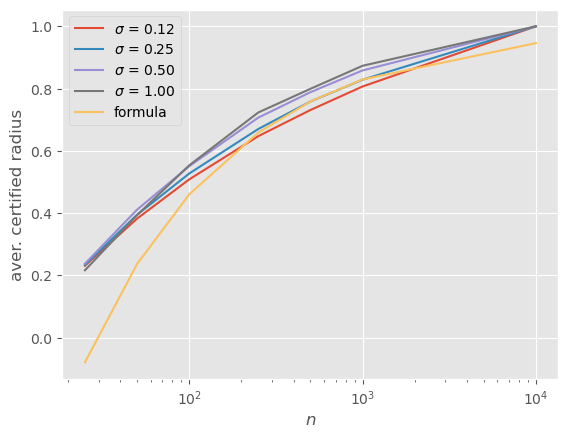

In [9]:
sigmas_str = ['0.12', '0.25', '0.50', '1.00']
ns = np.array([25, 50, 100, 250, 500, 1000, 10000])

for i in range(len(rA_all_cifar)):
    y = rA_all_cifar[i]
    y /= y.max()
    
    plt.plot(ns, y, label = '$\sigma$ = ' + sigmas_str[i])
# end for

# plot also formula
plt.plot(ns, Rbar(ns), label = 'formula')
# add a legend to the plot
plt.legend()
# add x and y labels
plt.xlabel('$n$')
plt.xscale('log')
plt.ylabel('aver. certified radius')
plt.show()

### Average certified radius - ImageNet

Similarly we run the experiments if results are not available. This will take several hours.

In [ ]:
# uncomment and run to run all experiments from scratch - will take a lot of time
#!python 'run_all_imagenet.py'

In [10]:
with open('results/rA_all_imagenet.pickle', 'rb') as file:
    # load saved results
    rA_all_imagenet = pickle.load(file)
rA_all_imagenet = np.array(rA_all_imagenet)

As before, we plot the average certified radius reduction for each noise level $\sigma$ and sample size $n$ for ImageNet, for the models of (Cohen et al., 2019) (with $a = 0.001$), along with the predictions of eq. (2). We see e.g. that a reduction of $n$ from 100k to 1k reduces the aver. certified radius by just 20%, while a reduction from 100k to 100 reduces it to around 50%. We again observe good agreement with eq. (2).

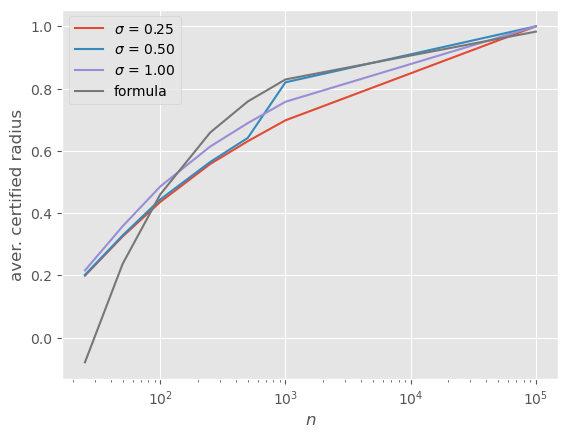

In [11]:
sigmas_str = ['0.25', '0.50', '1.00']
ns = np.array([25, 50, 100, 250, 500, 1000, 100000])

for i in range(len(rA_all_imagenet)):
    y = rA_all_imagenet[i]
    y /= y.max()
    
    plt.plot(ns, y, label = '$\sigma$ = ' + sigmas_str[i])
# end for

# plot also formula
plt.plot(ns, Rbar(ns), label = 'formula')
# add a legend to the plot
plt.legend()
# add x and y labels
plt.xlabel('$n$')
plt.xscale('log')
plt.ylabel('aver. certified radius')
plt.show()

We also provide code to run similar experiments using the models of (Salman et al., 2019) (https://arxiv.org/abs/1906.04584), where the authors use adversarial training to improve smooth classifiers. We find again good agreement with eq. (2) and (3).

### Average certified accuracy reduction - CIFAR10

We also compare the predictions of eq. (3) to the experimental results. First, we plot the certified accuracy of the models at each radius for $\sigma = 0.5$, with respect to the number of samples.

In [19]:
# formula for average certified accuracy drop - eq. (3)
def z(a = 0.001):
    return norm.ppf( 1 - a/2 )

def dacc(n, a = 0.001):
    return z(a) / n**0.5

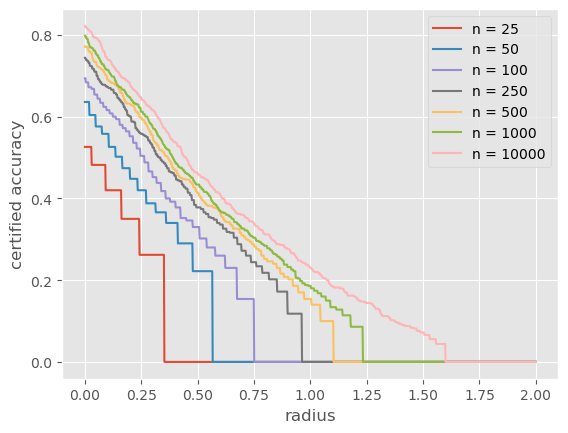

In [18]:
# read all files - cifar, sigma = 0.5
fpath1 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_25_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'
fpath2 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_50_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'
fpath3 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_100_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'
fpath4 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_250_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'
fpath5 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_500_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'
fpath6 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_1000_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'
fpath7 = 'results/results_RS_nopred_cifar10_cifar_resnet110_sigma_0.5_N_10000_alpha_0.001_certbatch_5000_nclasses_10_skip_20.pkl'

fpaths = [fpath1, fpath2, fpath3, fpath4, fpath5, fpath6, fpath7]

ns = np.array([25, 50, 100, 250, 500, 1000, 10000])


# for all files, compute cert. acc
for i in range(len(fpaths)):
    # read the file
    results = pd.read_pickle(fpaths[i])
    
    # calc cert acc
    rmin = 0
    #rmax = results['radius'].max()
    rmax = 2
    radii = np.linspace(rmin, rmax, 1000)
    cacc = np.zeros( len(radii) ) # cert acc at each radius
    for j in range(len(radii)):
        cacc[j] = (results['radius'] > radii[j]).sum() / len(results['radius'])
    
    # plot it with corresponding label
    plt.plot(radii, cacc, label = 'n = ' + str(ns[i]))
# add legend to the plot
plt.legend()
#plt.xlabel('radius ($L_2$)')
plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.show() 

Now, for each valuen of $n$, we calculate the average reduction in the certified accuracy over all radii, and compare it with eq. (3).

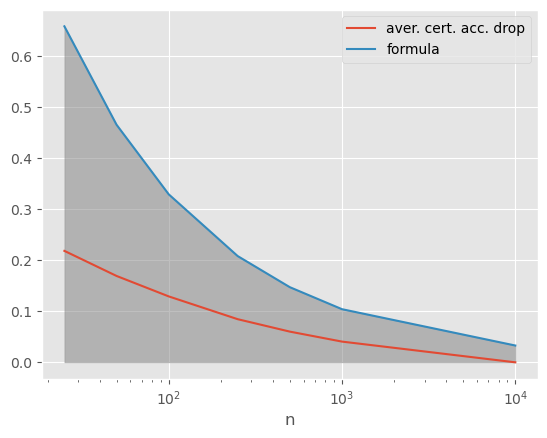

In [20]:
# calculate cert. acc (cacc) for all files
radii = np.linspace(0, 2, 1000)
cacc_all = np.zeros( (len(fpaths), len(radii)) )

for i in range(len(fpaths)):
    # read the file
    results = pd.read_pickle(fpaths[i])

    for j in range(len(radii)):
        cacc_all[i][j] = (results['radius'] > radii[j]).sum() / len(results['radius'])

# record the average deviation for each n from the max
diffs = np.zeros(len(fpaths))

for i in range(len(diffs)):
    delta = (cacc_all[-1] - cacc_all[i]).mean()
    diffs[i] = delta

# calc formula for diffs
diffs_fmla = dacc(ns)


# plot diffs vs diffs_fmla
plt.plot(ns, diffs, label = 'aver. cert. acc. drop')
plt.plot(ns, diffs_fmla, label = 'formula')
y_lower_bound = 0
plt.fill_between(ns, y_lower_bound, diffs_fmla, color = 'gray', alpha = 0.5)
# add legend
plt.legend()
plt.xlabel('n')
plt.xscale('log')
#plt.ylabel('%')
plt.show() 

We observe that the drop in certified accuracy is within the range predicted by eq. (3), as expected. Moreover, we see e.g. than reducing $n$ from 10k to 100 reduces the certified accuracy by only about 12% (on average over the radii).

### Average certified accuracy reduction - ImageNet

We perform the experiment also for ImageNet and find similar results.

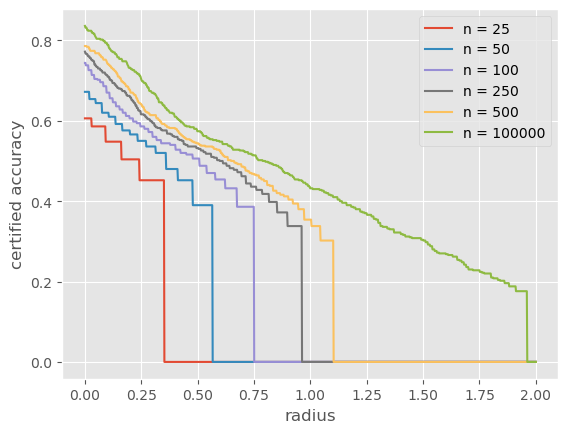

In [24]:
# read all files - imagenet, sigma = 0.5
fpath1 = 'results/results_RS_ImageNet_nopred_imagenet_resnet50_sigma_0.5_N_25_alpha_0.001_certbatch_100_nclasses_1000_skip_100.pkl'
fpath2 = 'results/results_RS_ImageNet_nopred_imagenet_resnet50_sigma_0.5_N_50_alpha_0.001_certbatch_100_nclasses_1000_skip_100.pkl'
fpath3 = 'results/results_RS_ImageNet_nopred_imagenet_resnet50_sigma_0.5_N_100_alpha_0.001_certbatch_100_nclasses_1000_skip_100.pkl'
fpath4 = 'results/results_RS_ImageNet_nopred_imagenet_resnet50_sigma_0.5_N_250_alpha_0.001_certbatch_100_nclasses_1000_skip_100.pkl'
fpath5 = 'results/results_RS_ImageNet_nopred_imagenet_resnet50_sigma_0.5_N_500_alpha_0.001_certbatch_100_nclasses_1000_skip_100.pkl'
fpath6 = 'results/results_RS_ImageNet_nopred_imagenet_resnet50_sigma_0.5_N_100000_alpha_0.001_certbatch_100_nclasses_1000_skip_100.pkl'

fpaths = [fpath1, fpath2, fpath3, fpath4, fpath5, fpath6]

ns = np.array([25, 50, 100, 250, 500, 100000])


# for all files, compute cacc
for i in range(len(fpaths)):
    # read the file
    results = pd.read_pickle(fpaths[i])
    
    # calc cert acc
    rmin = 0
    #rmax = results['radius'].max()
    rmax = 2
    radii = np.linspace(rmin, rmax, 1000)
    cacc = np.zeros( len(radii) ) # cert acc at each radius
    for j in range(len(radii)):
        cacc[j] = (results['radius'] > radii[j]).sum() / len(results['radius'])
    
    # plot it with corresponding label
    plt.plot(radii, cacc, label = 'n = ' + str(ns[i]))
# add legend
plt.legend()
#plt.xlabel('radius ($L_2$)')
plt.xlabel('radius')
plt.ylabel('certified accuracy')
plt.show() 

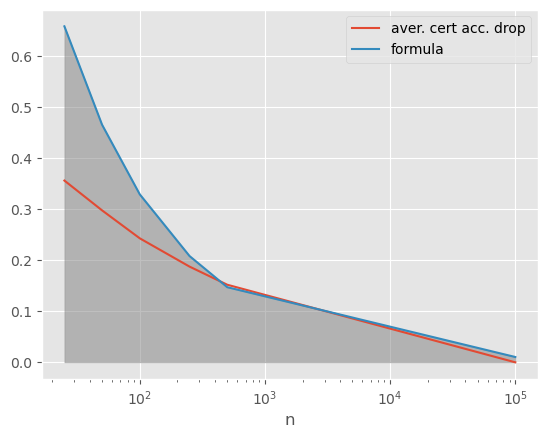

In [25]:
# calculate cacc for all files
radii = np.linspace(0, 2, 1000)
cacc_all = np.zeros( (len(fpaths), len(radii)) )

for i in range(len(fpaths)):
    # read the file
    results = pd.read_pickle(fpaths[i])

    for j in range(len(radii)):
        cacc_all[i][j] = (results['radius'] > radii[j]).sum() / len(results['radius'])

# record the average deviation for each n from the max
diffs = np.zeros(len(fpaths))

for i in range(len(diffs)):
    delta = (cacc_all[-1] - cacc_all[i]).mean()
    diffs[i] = delta

# calc forluma for diffs
diffs_fmla = dacc(ns)


# plot diffs vs diffs_fmla
plt.plot(ns, diffs, label = 'aver. cert acc. drop')
plt.plot(ns, diffs_fmla, label = 'formula')
y_lower_bound = 0
plt.fill_between(ns, y_lower_bound, diffs_fmla, color = 'gray', alpha = 0.5)
# add legend
plt.legend()
#plt.xlabel('radius ($L_2$)')
plt.xlabel('n')
plt.xscale('log')
#plt.ylabel('%')
plt.show() 

For example, we observe that reducing $n$ from 100k to 100 reduces the certified accuracy by about 25% (on average over radii).